# Initial clean

Try to remove outliers where the "block" just doesn't match the geo-coding

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os, lzma, csv, bz2, io, collections, pickle
import pyproj
import tilemapbase
import shapely.geometry

import open_cp.sources.chicago

In [2]:
data_dir = os.path.join("/media", "disk", "Data")
#data_dir = os.path.join("..", "..", "..", "..", "Data")
#os.listdir(data_dir)
filename = os.path.join(data_dir, "chicago_all.csv.xz")

In [162]:
with lzma.open(filename, "rt", encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
    out = collections.defaultdict(list)
    out_indices = collections.defaultdict(list)
    original_rows = []
    for row in reader:
        if row[15] == "":
            continue
        year = int(row[17])
        if year <= 2001:
            continue
        block, x, y = row[3], float(row[15]), float(row[16])
        x /= open_cp.sources.chicago._FEET_IN_METERS
        y /= open_cp.sources.chicago._FEET_IN_METERS
        if x < 10 or y < 10:
            continue
        out[block].append((x,y))
        out_indices[block].append(len(original_rows))
        original_rows.append((block, x, y, row[2], row[5], row[6], row[7]))
out = {k : np.asarray(out[k]) for k in out}
out_indices = {k : np.asarray(out_indices[k]) for k in out_indices}
len(out)

51465

In [65]:
proj = pyproj.Proj({"init":"epsg:3528"})

# Find outliers

These are:
- One-off errors, where a single entry from a "block" is just wrong
- Systematic errors where the "block" is "NORTH" but the geo-coding is the "SOUTH" part of the street; or EAST/WEST
- Some special cases, like airports, or diagonal streets
- A one-off error which we cannot catch automatically

I am puzzled by the North/South thing.  This must be a data entry error, but _how_ do the coordinates and the address get out of sync, as surely one is machine generated from the other??

In [466]:
rects = {}
i = 51000

allowed = {'0000X W TERMINAL ST', '013XX S LYNN WHITE DR', '073XX N ROGERS AVE', '022XX S ARCHER AVE',
    '051XX S ARCHER AVE', '030XX S ARCHER AVE', '050XX S ARCHER AVE', '001XX N BESSIE COLEMAN DR',
    '025XX S BLUE ISLAND AVE', '0000X W DOOR D ST', '067XX N HIAWATHA AVE', '057XX N ROGERS AVE',
    '030XX S ARCHER AV', '0000X W DOOR G ST', '0000X W DOOR C ST'}
for key in out:
    if key.endswith(" W OHARE ST"):
        allowed.add(key)
allowed.remove('006XX W OHARE ST')

rejected = []
cleaned = {}

for key in out:
    if key in allowed:
        cleaned[key] = out[key]
        continue
    data = out[key]
    def f(a):
        return score(a, data)
    angle = scipy.optimize.brute(f, [[0, np.pi]])[0]
    xcs, ycs = to_coords(angle, data)
    
    def part(x):
        return np.max(np.abs(xcs-x))
    x = scipy.optimize.brute(part, [[np.min(xcs), np.max(xcs)]])[0]
    if part(x) > 200:
        before, after = xcs < x, xcs >= x
        if key == '003XX N PEORIA ST':
            print("Doing odd case:", np.sum(before), np.sum(after))
            use, rej = before, after
        elif np.sum(before) < np.sum(after):
            use, rej = after, before
        else:
            use, rej = before, after
        rejected.extend(out_indices[key][rej])
        cleaned[key] = out[key][use]
    else:
        cleaned[key] = out[key]

Doing odd case: 20 24


In [467]:
# Tiny subset...
len(rejected)

489

In [468]:
assert set(out.keys()) == set(cleaned.keys())
assert sum( len(x) for x in out.values() ) == sum( len(x) for x in cleaned.values() ) + len(rejected)

In [490]:
rejected = set(rejected)

data_dir = os.path.join("/media", "disk", "Data")
#data_dir = os.path.join("..", "..", "..", "..", "Data")
outfilename = os.path.join(data_dir, "chicago_all_cleaned.csv.xz")

with lzma.open(filename, "rt", encoding="utf8") as f:
    with lzma.open(outfilename, "wt", encoding="utf8") as fout:
        reader = csv.reader(f)
        writer = csv.writer(fout)
        header = next(reader)
        writer.writerow(header)
        count = 0
        for row in reader:
            if row[15] == "":
                continue
            year = int(row[17])
            if year <= 2001:
                continue
            block, x, y = row[3], float(row[15]), float(row[16])
            x /= open_cp.sources.chicago._FEET_IN_METERS
            y /= open_cp.sources.chicago._FEET_IN_METERS
            if x < 10 or y < 10:
                continue
            if count not in rejected:
                writer.writerow(row)
            count += 1

## Only needed in construction: Visualing the errors...

In [463]:
i, key = None, '006XX W OHARE ST'

data = out[key]
def f(a):
    return score(a, data)
angle = scipy.optimize.brute(f, [[0, np.pi]])[0]
xcs, ycs = to_coords(angle, data)

def part(x):
    return np.max(np.abs(xcs-x))
x = scipy.optimize.brute(part, [[np.min(xcs), np.max(xcs)]])[0]
if part(x) > 200:
    before, after = xcs < x, xcs >= x

(None, '006XX W OHARE ST')

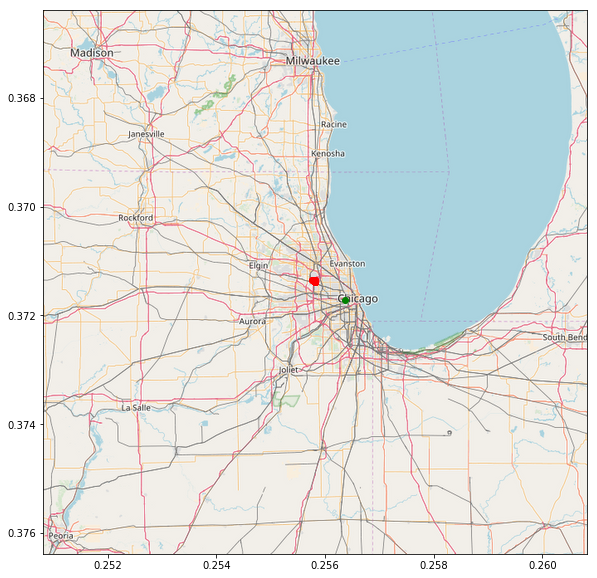

In [464]:
pts = out[key]
pts = proj(*pts.T, inverse=True)
ptstmb = []
for x,y in zip(*pts):
    ptstmb.append( tilemapbase.project(x, y) )
ptstmb = np.array(ptstmb).T
    
fig, ax = plt.subplots(figsize=(10,10))

xmin, xmax = np.min(ptstmb[0]), np.max(ptstmb[0])
ymin, ymax = np.min(ptstmb[1]), np.max(ptstmb[1])
x, y = np.mean(ptstmb[0]), np.mean(ptstmb[1])
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.01)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)

ax.scatter(*ptstmb.T[before].T, color="red")
ax.scatter(*ptstmb.T[after].T, color="green")
#ax.scatter(*ptstmb)
i, key

In [426]:
for i in out_indices[key][before]:
    print(original_rows[i])

('025XX S BLUE ISLAND AV', 354242.2062642494, 575296.5703905098, '02/20/2002 10:30:00 AM', 'ASSAULT', 'SIMPLE', 'RESIDENCE')
('025XX S BLUE ISLAND AV', 354242.2062642494, 575296.5703905098, '04/14/2002 02:40:32 PM', 'ROBBERY', 'STRONGARM - NO WEAPON', 'STREET')


In [427]:
for i in out_indices[key][after]:
    print(original_rows[i])

('025XX S BLUE ISLAND AV', 353978.24947269604, 575159.1055949086, '01/16/2002 05:25:48 AM', 'THEFT', '$500 AND UNDER', 'SIDEWALK')
('025XX S BLUE ISLAND AV', 353932.2246741688, 575135.0263956791, '01/13/2002 01:21:00 PM', 'BATTERY', 'AGGRAVATED: OTHER DANG WEAPON', 'SIDEWALK')
('025XX S BLUE ISLAND AV', 353940.4542739055, 575139.2935955427, '01/19/2002 11:25:37 AM', 'ARSON', 'BY FIRE', 'VEHICLE NON-COMMERCIAL')
('025XX S BLUE ISLAND AV', 353836.51747723145, 575084.7343972885, '02/16/2002 08:15:00 AM', 'CRIMINAL DAMAGE', 'TO PROPERTY', 'SMALL RETAIL STORE')
('025XX S BLUE ISLAND AV', 353951.4270735543, 575145.0847953573, '03/03/2002 09:10:00 PM', 'WEAPONS VIOLATION', 'UNLAWFUL POSS OF HANDGUN', 'RESIDENCE')
('025XX S BLUE ISLAND AV', 353951.4270735543, 575145.0847953573, '03/24/2002 03:50:51 AM', 'BATTERY', 'SIMPLE', 'STREET')
